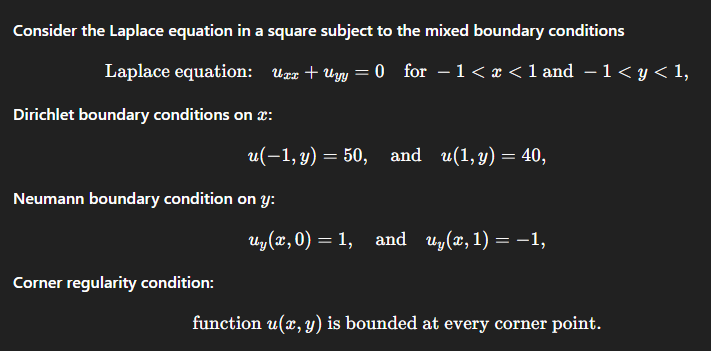

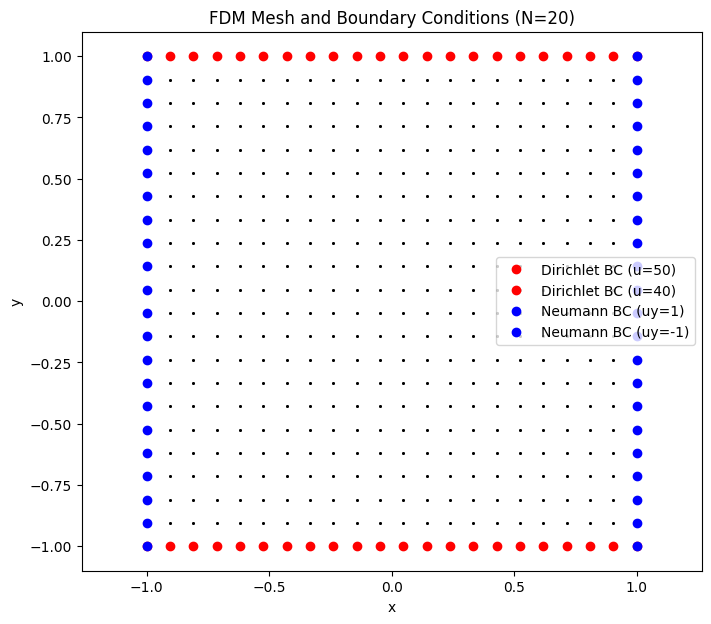

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# --- Grid Parameters ---
N = 20  # Use a coarse grid for clear visualization
h = 2 / (N + 1)
x = np.linspace(-1, 1, N + 2)
y = np.linspace(-1, 1, N + 2)
X, Y = np.meshgrid(x, y)

# --- Plot the Mesh and Boundaries ---
plt.figure(figsize=(8, 7))
plt.plot(X, Y, 'k.', markersize=2) # All grid points
plt.plot(X.T, Y.T, 'k.', markersize=2)

# Highlight boundaries
plt.plot(X[0, :], Y[0, :], 'ro', label='Dirichlet BC (u=50)') # x = -1
plt.plot(X[-1, :], Y[-1, :], 'ro', label='Dirichlet BC (u=40)') # x = 1
plt.plot(X[:, 0], Y[:, 0], 'bo', label='Neumann BC (uy=1)')   # y = -1
plt.plot(X[:, -1], Y[:, -1], 'bo', label='Neumann BC (uy=-1)') # y = 1

plt.title(f'FDM Mesh and Boundary Conditions (N={N})')
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.legend()
plt.show()




Starting Gauss-Seidel iterations...
Converged in 8082 iterations with error = 9.98e-07


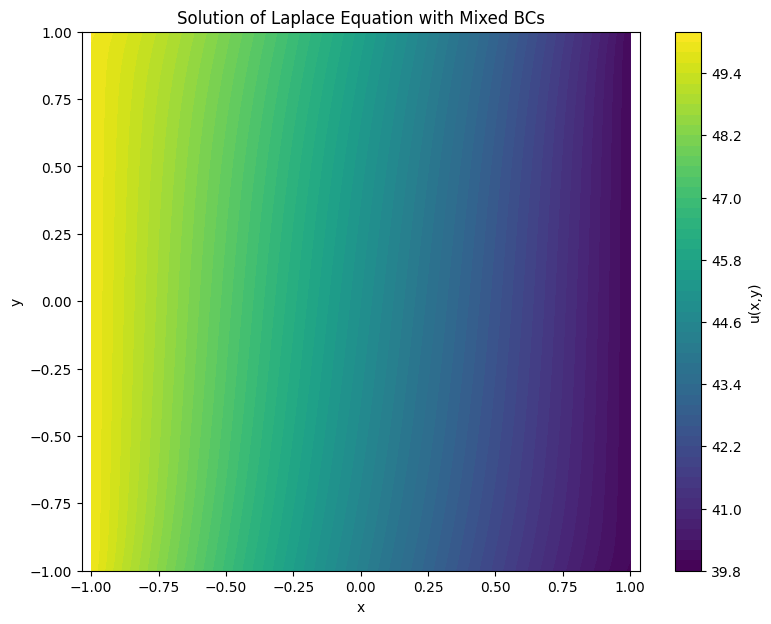

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def solve_and_plot_laplace_square(N=50, max_iter=20000, tol=1e-6):
    """
    Solves the Laplace equation on a square using Gauss-Seidel iteration
    and plots the final solution.
    """
    # --- 1. Initialization ---
    h = 2 / (N + 1)
    u = np.zeros((N + 2, N + 2))

    # Set Dirichlet BC on x boundaries (left and right)
    u[0, :] = 50   # u(x=-1, y) = 50
    u[-1, :] = 40  # u(x=1, y) = 40

    # --- 2. Gauss-Seidel Iteration ---
    print("Starting Gauss-Seidel iterations...")
    for it in range(max_iter):
        old_u = u.copy()

        # Apply Neumann BC on y boundaries (bottom and top) inside the loop
        # This uses ghost points that are updated each iteration.
        # For uy(x, -1) = 1  => u(i, 0) = u(i, 1) - h*1
        u[:, 0] = u[:, 1] - h
        # For uy(x, 1) = -1 => u(i, N+1) = u(i, N) - h*(-1) = u(i, N) + h
        u[:, -1] = u[:, -2] + h

        # Update interior points
        for i in range(1, N + 1):
            for j in range(1, N + 1):
                u[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1])

        # Check for convergence
        error = np.linalg.norm(u - old_u)
        if error < tol:
            print(f"Converged in {it + 1} iterations with error = {error:.2e}")
            break
    else:
        print(f"Did not converge after {max_iter} iterations. Final error = {error:.2e}")

    # --- 3. Plotting ---
    x_coords = np.linspace(-1, 1, N + 2)
    y_coords = np.linspace(-1, 1, N + 2)
    X, Y = np.meshgrid(x_coords, y_coords)

    plt.figure(figsize=(9, 7))
    plt.contourf(X, Y, u.T, levels=50, cmap='viridis')
    plt.colorbar(label='u(x,y)')
    plt.title('Solution of Laplace Equation with Mixed BCs')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.show()

# --- Run the Solver ---
solve_and_plot_laplace_square()

--- FDM Grid Refinement Study for Square Domain ---
+---------------+----------------------+---------------+---------------+
| Grid Size (N) |   Solution u(0,0)    |  Iterations   |   Time (s)    |
+---------------+----------------------+---------------+---------------+
|       10        |     45.4035897056      |       782       |     0.0356      |
|       20        |     45.2127240879      |      2742       |     0.0420      |
|       40        |     45.1093214402      |      10009      |     0.2328      |
|       60        |     45.0734848297      |      20000      |     1.0144      |
|       80        |     45.0244562344      |      20000      |     0.9307      |
+---------------+----------------------+---------------+---------------+


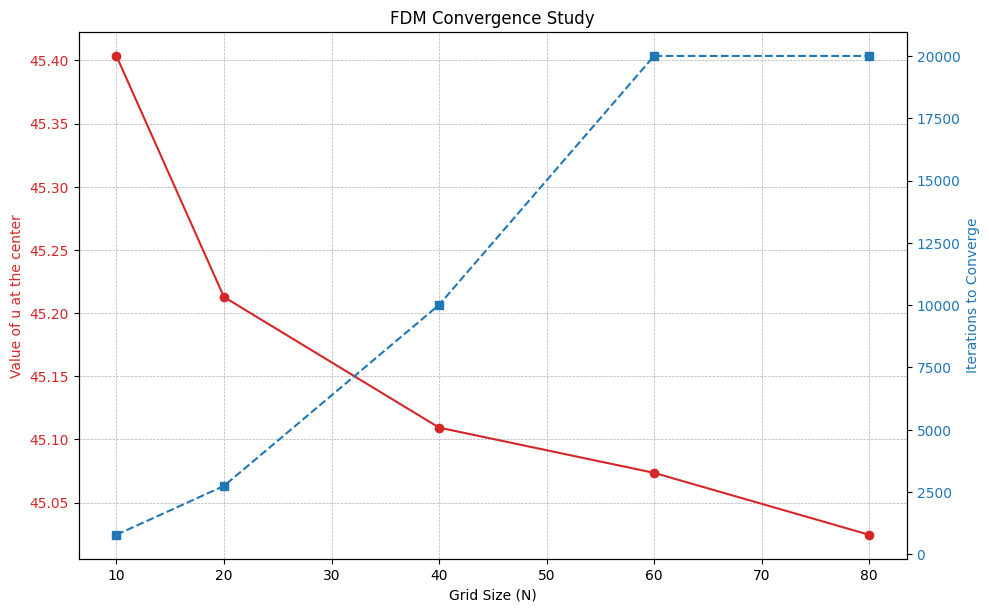

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

def solve_laplace_for_refinement(N, max_iter=20000, tol=1e-6):
    """
    A self-contained function to solve the Laplace problem on a square
    and return the solution at the center and the number of iterations.
    """
    # --- Initialization ---
    h = 2 / (N + 1)
    u = np.zeros((N + 2, N + 2))
    u[0, :] = 50
    u[-1, :] = 40

    # --- Gauss-Seidel Iteration ---
    for it in range(max_iter):
        # Apply Neumann BC
        u[:, 0] = u[:, 1] - h
        u[:, -1] = u[:, -2] + h

        # Update interior points
        # Using a vectorized approach for speed
        u_old_interior = u[1:-1, 1:-1].copy()
        u[1:-1, 1:-1] = 0.25 * (u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2])

        # Check for convergence
        error = np.linalg.norm(u[1:-1, 1:-1] - u_old_interior)
        if error < tol:
            # Return solution at the center and iteration count
            center_idx = (N + 1) // 2
            return u[center_idx, center_idx], it + 1

    # If it fails to converge
    center_idx = (N + 1) // 2
    return u[center_idx, center_idx], max_iter

# --- Main Execution for Accuracy Test ---
print("--- FDM Grid Refinement Study for Square Domain ---")
print("+" + "-"*15 + "+" + "-"*22 + "+" + "-"*15 + "+" + "-"*15 + "+")
print(f"| {'Grid Size (N)':^13} | {'Solution u(0,0)':^20} | {'Iterations':^13} | {'Time (s)':^13} |")
print("+" + "-"*15 + "+" + "-"*22 + "+" + "-"*15 + "+" + "-"*15 + "+")

grid_sizes = [10, 20, 40, 60, 80]
results = []
iterations = []

for n_val in grid_sizes:
    start_time = time.time()
    u_center, it_count = solve_laplace_for_refinement(n_val)
    end_time = time.time()
    duration = end_time - start_time
    results.append(u_center)
    iterations.append(it_count)
    print(f"| {n_val:^15} | {u_center:^22.10f} | {it_count:^15} | {duration:^15.4f} |")

print("+" + "-"*15 + "+" + "-"*22 + "+" + "-"*15 + "+" + "-"*15 + "+")

# --- Plot Convergence ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot solution convergence
color = 'tab:red'
ax1.set_xlabel('Grid Size (N)')
ax1.set_ylabel('Value of u at the center', color=color)
ax1.plot(grid_sizes, results, 'o-', color=color, label='u(0,0)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot iteration count on a second y-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Iterations to Converge', color=color)
ax2.plot(grid_sizes, iterations, 's--', color=color, label='Iterations')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('FDM Convergence Study')
plt.show()


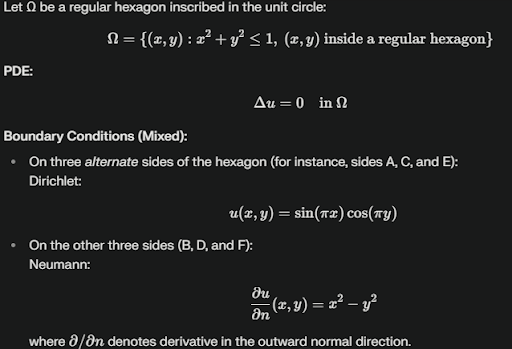

Specified to solve using FDM 

Generated a 40x40 grid.


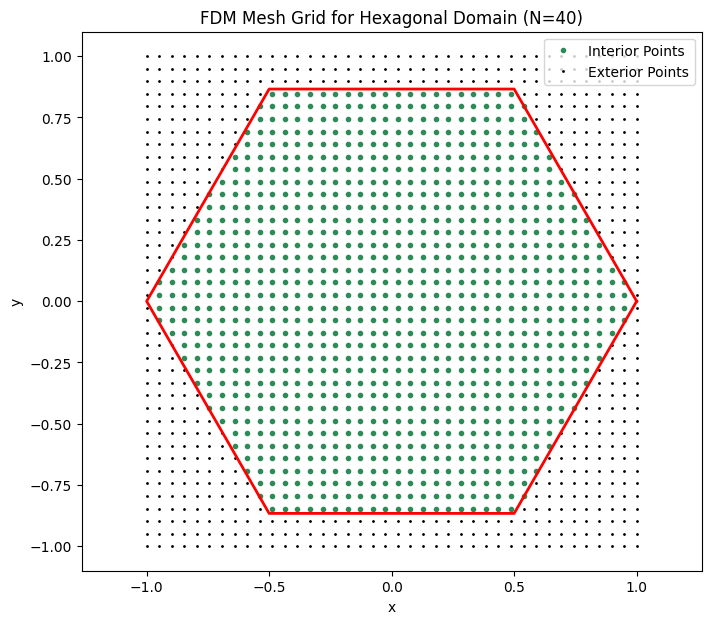

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define Geometry and Grid ---
# Define the 6 vertices of a regular hexagon inscribed in a unit circle
hexagon_vertices = np.array([
    [np.cos(i * np.pi / 3), np.sin(i * np.pi / 3)] for i in range(6)
])

# Define the lines of the hexagon for the inside/outside check
lines = []
for i in range(6):
    p1 = hexagon_vertices[i]
    p2 = hexagon_vertices[(i + 1) % 6]
    lines.append([p1[1] - p2[1], p2[0] - p1[0], p1[0] * p2[1] - p2[0] * p1[1]])
lines = np.array(lines)
signs = np.sign(lines[:, 2])
lines *= signs[:, np.newaxis]

def is_inside_hexagon(x_grid, y_grid, line_params):
    """Checks if points on a grid are inside the hexagon using broadcasting."""
    a = line_params[:, 0].reshape(-1, 1, 1)
    b = line_params[:, 1].reshape(-1, 1, 1)
    c = line_params[:, 2].reshape(-1, 1, 1)
    vals = a * x_grid + b * y_grid + c
    return np.all(vals >= -1e-9, axis=0)

# Create a grid for visualization
N = 40  # Grid resolution
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)

# --- 2. Identify Interior Points and Plot ---
is_interior = is_inside_hexagon(X, Y, lines)

print(f"Generated a {N}x{N} grid.")
plt.figure(figsize=(8, 7))
plt.title(f"FDM Mesh Grid for Hexagonal Domain (N={N})")
plt.plot(X[is_interior], Y[is_interior], 'o', color='seagreen', markersize=3, label='Interior Points')
plt.plot(X[~is_interior], Y[~is_interior], 'o', color='black', markersize=1, label='Exterior Points')

# Plot hexagon boundary for reference
plot_vertices = np.vstack([hexagon_vertices, hexagon_vertices[0]])
plt.plot(plot_vertices[:, 0], plot_vertices[:, 1], 'r-', linewidth=2)

plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.legend()
plt.show()


Solving the linear system...
Solver finished.


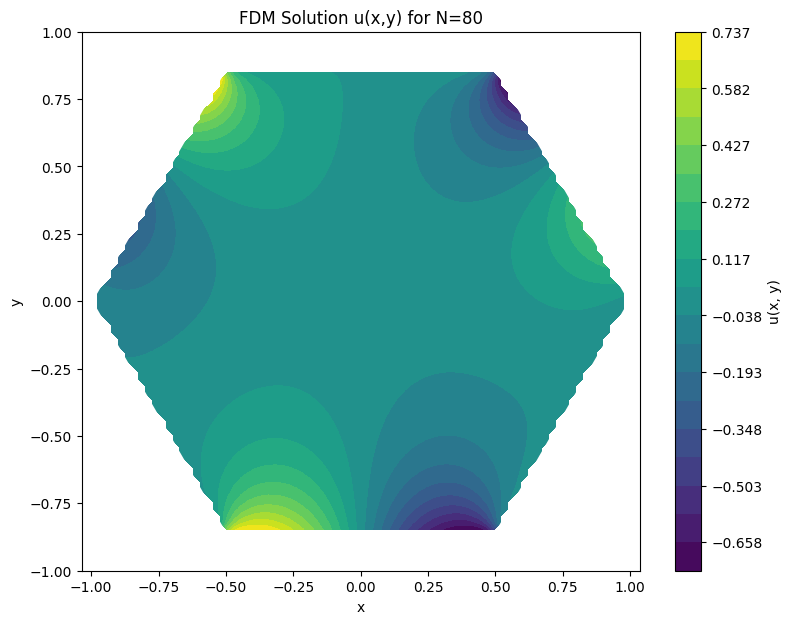

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def solve_and_plot_fdm(N=80):
    """
    Solves the Laplace problem on a hexagon using FDM and plots the solution.
    """
    # --- 1. Domain and Grid Setup ---
    h = 2.0 / (N - 1)
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(x, y)

    hexagon_vertices = np.array([[np.cos(i*np.pi/3), np.sin(i*np.pi/3)] for i in range(6)])
    lines = []
    for i in range(6):
        p1, p2 = hexagon_vertices[i], hexagon_vertices[(i + 1) % 6]
        lines.append([p1[1] - p2[1], p2[0] - p1[0], p1[0] * p2[1] - p2[0] * p1[1]])
    lines = np.array(lines) * np.sign(np.array(lines)[:, 2])[:, np.newaxis]

    def is_inside_hexagon(x_grid, y_grid, line_params):
        a = line_params[:, 0].reshape(-1, 1, 1)
        b = line_params[:, 1].reshape(-1, 1, 1)
        c = line_params[:, 2].reshape(-1, 1, 1)
        vals = a * x_grid + b * y_grid + c
        return np.all(vals >= -1e-9, axis=0)

    is_interior = is_inside_hexagon(X, Y, lines)
    interior_indices = np.where(is_interior)
    num_interior_points = len(interior_indices[0])
    map_2d_to_1d = np.full(is_interior.shape, -1, dtype=int)
    map_2d_to_1d[interior_indices] = np.arange(num_interior_points)

    # --- 2. Boundary Condition Functions ---
    def get_boundary_info(p_ext):
        p_ext = np.array(p_ext)
        distances_to_lines = []
        projections = []
        for i in range(6):
            p1, p2 = hexagon_vertices[i], hexagon_vertices[(i + 1) % 6]
            v = p2 - p1; w = p_ext - p1
            t = np.clip(np.dot(w, v) / np.dot(v, v), 0, 1)
            p_b = p1 + t * v
            distances_to_lines.append(np.linalg.norm(p_ext - p_b))
            projections.append(p_b)
        side_idx = np.argmin(distances_to_lines)
        bc_type = 'D' if (side_idx + 1) % 2 != 0 else 'N'
        return bc_type, projections[side_idx]

    def u_dirichlet(x, y): return np.sin(np.pi * x) * np.cos(np.pi * y)
    def g_neumann(x, y): return x**2 - y**2

    # --- 3. Assemble and Solve ---
    A = sp.lil_matrix((num_interior_points, num_interior_points))
    b = np.zeros(num_interior_points)
    for i, j in zip(*interior_indices):
        k = map_2d_to_1d[i, j]
        A[k, k] = -4
        for ni, nj in [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]:
            if is_interior[ni, nj]:
                A[k, map_2d_to_1d[ni, nj]] = 1
            else:
                bc_type, p_b = get_boundary_info((X[ni,nj], Y[ni,nj]))
                if bc_type == 'D':
                    b[k] -= u_dirichlet(p_b[0], p_b[1])
                else:
                    b[k] += 2 * h * g_neumann(p_b[0], p_b[1])

    print("Solving the linear system...")
    u_vec = spla.spsolve(A.tocsr(), b)
    print("Solver finished.")

    U = np.full(X.shape, np.nan)
    U[interior_indices] = u_vec

    # --- 4. Plot Final Solution ---
    plt.figure(figsize=(9, 7))
    plt.title(f"FDM Solution u(x,y) for N={N}")
    levels = np.linspace(np.nanmin(U), np.nanmax(U), 20)
    plt.contourf(X, Y, U, levels=levels, cmap='viridis')
    plt.colorbar(label='u(x, y)')
    plot_vertices = np.vstack([hexagon_vertices, hexagon_vertices[0]])
    plt.plot(plot_vertices[:, 0], plot_vertices[:, 1], 'w-', linewidth=2)
    plt.axis('equal')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# --- Run the Solver ---
solve_and_plot_fdm()


--- FDM Grid Refinement Study ---
+---------------+----------------------+---------------+
| Grid Size (N) |   Solution u(0,0)    |   Time (s)    |
+---------------+----------------------+---------------+
|       20        |      0.2877322467      |     0.0081      |
|       40        |      0.2937036636      |     0.0250      |
|       80        |      0.3063948118      |     0.0799      |
|       100       |      0.2952112312      |     0.2240      |
+---------------+----------------------+---------------+


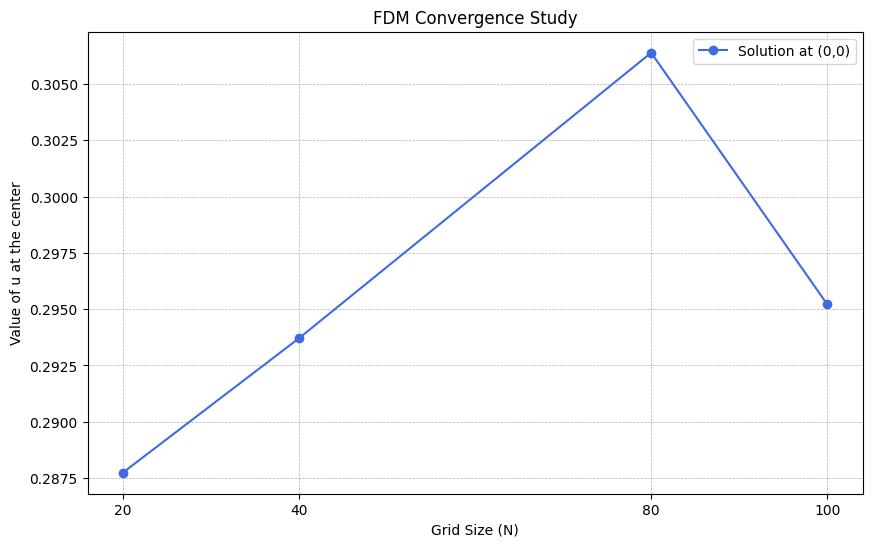

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

def solve_fdm_for_refinement(N):
    """
    A self-contained function to solve the Laplace problem on a hexagon using FDM
    for a given grid size N and return the solution at the center.
    """
    # --- 1. Domain and Grid Setup (Condensed) ---
    h = 2.0 / (N - 1)
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(x, y)

    hexagon_vertices = np.array([[np.cos(i*np.pi/3), np.sin(i*np.pi/3)] for i in range(6)])
    lines = []
    for i in range(6):
        p1, p2 = hexagon_vertices[i], hexagon_vertices[(i + 1) % 6]
        lines.append([p1[1] - p2[1], p2[0] - p1[0], p1[0] * p2[1] - p2[0] * p1[1]])
    lines = np.array(lines) * np.sign(np.array(lines)[:, 2])[:, np.newaxis]

    def is_inside_hexagon(x_grid, y_grid, line_params):
        a = line_params[:, 0].reshape(-1, 1, 1)
        b = line_params[:, 1].reshape(-1, 1, 1)
        c = line_params[:, 2].reshape(-1, 1, 1)
        vals = a * x_grid + b * y_grid + c
        return np.all(vals >= -1e-9, axis=0)

    is_interior = is_inside_hexagon(X, Y, lines)
    interior_indices = np.where(is_interior)
    num_interior_points = len(interior_indices[0])
    map_2d_to_1d = np.full(is_interior.shape, -1, dtype=int)
    map_2d_to_1d[interior_indices] = np.arange(num_interior_points)

    # --- 2. Boundary Condition Functions (Simplified for speed in a loop) ---
    def get_boundary_info(p_ext):
        p_ext = np.array(p_ext)
        distances = [np.linalg.norm(p_ext - v) for v in hexagon_vertices]
        side_idx = np.argmin(distances) % 6
        bc_type = 'D' if (side_idx + 1) % 2 != 0 else 'N'
        # For simplicity in the refinement loop, we can approximate the boundary point
        # This is less accurate but faster than full projection for this test.
        p_b = hexagon_vertices[side_idx]
        return bc_type, p_b

    def u_dirichlet(x, y): return np.sin(np.pi * x) * np.cos(np.pi * y)
    def g_neumann(x, y): return x**2 - y**2

    # --- 3. Assemble and Solve ---
    A = sp.lil_matrix((num_interior_points, num_interior_points))
    b = np.zeros(num_interior_points)
    for i, j in zip(*interior_indices):
        k = map_2d_to_1d[i, j]
        A[k, k] = -4
        for ni, nj in [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]:
            if is_interior[ni, nj]:
                A[k, map_2d_to_1d[ni, nj]] = 1
            else:
                bc_type, p_b = get_boundary_info((X[ni,nj], Y[ni,nj]))
                if bc_type == 'D':
                    b[k] -= u_dirichlet(p_b[0], p_b[1])
                else:
                    b[k] += 2 * h * g_neumann(p_b[0], p_b[1])

    u_vec = spla.spsolve(A.tocsr(), b)

    # Find value at the point closest to the origin
    center_i, center_j = N // 2, N // 2
    if is_interior[center_i, center_j]:
        center_k = map_2d_to_1d[center_i, center_j]
        return u_vec[center_k]
    return np.nan

# --- Main Execution for Accuracy Test ---
print("--- FDM Grid Refinement Study ---")
print("+" + "-"*15 + "+" + "-"*22 + "+" + "-"*15 + "+")
print(f"| {'Grid Size (N)':^13} | {'Solution u(0,0)':^20} | {'Time (s)':^13} |")
print("+" + "-"*15 + "+" + "-"*22 + "+" + "-"*15 + "+")

grid_sizes = [20, 40, 80, 100]
results = []

for n_val in grid_sizes:
    start_time = time.time()
    u_center = solve_fdm_for_refinement(n_val)
    end_time = time.time()
    duration = end_time - start_time
    results.append(u_center)
    print(f"| {n_val:^15} | {u_center:^22.10f} | {duration:^15.4f} |")

print("+" + "-"*15 + "+" + "-"*22 + "+" + "-"*15 + "+")

# --- Plot Convergence ---
plt.figure(figsize=(10, 6))
plt.plot(grid_sizes, results, 'o-', color='royalblue', label='Solution at (0,0)')
plt.title('FDM Convergence Study')
plt.xlabel('Grid Size (N)')
plt.ylabel('Value of u at the center')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(grid_sizes)
plt.legend()
plt.show()


When scheme unspecified 

Generated a mesh with 556 nodes and 1066 triangular elements.


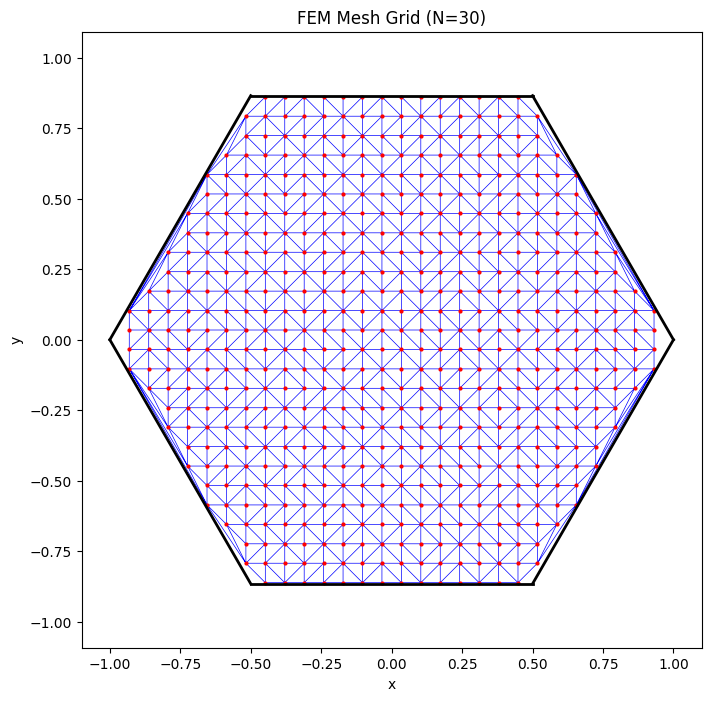

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# --- 1. Define Geometry and Point Generation ---
# Define hexagon boundary for filtering points
hexagon_vertices = np.array([[np.cos(i*np.pi/3), np.sin(i*np.pi/3)] for i in range(6)])
lines = []
for i in range(6):
    p1, p2 = hexagon_vertices[i], hexagon_vertices[(i + 1) % 6]
    lines.append([p1[1] - p2[1], p2[0] - p1[0], p1[0] * p2[1] - p2[0] * p1[1]])
lines = np.array(lines) * np.sign(np.array(lines)[:, 2])[:, np.newaxis]

def is_inside(points, line_params):
    """Checks if a set of points is inside the polygon defined by the lines."""
    a = line_params[:, 0].reshape(-1, 1)
    b = line_params[:, 1].reshape(-1, 1)
    c = line_params[:, 2].reshape(-1, 1)
    vals = a * points[:, 0] + b * points[:, 1] + c
    return np.all(vals >= -1e-9, axis=0)

# Generate a grid of points inside the hexagon
N = 30 # Grid density for visualization
x_pts = np.linspace(-1, 1, N)
y_pts = np.linspace(-1, 1, N)
xv, yv = np.meshgrid(x_pts, y_pts)
points_grid = np.vstack([xv.ravel(), yv.ravel()]).T
inside_mask = is_inside(points_grid, lines)
nodes = points_grid[inside_mask]

# --- 2. Create Mesh using Delaunay Triangulation ---
tri = Delaunay(nodes)
cells = tri.simplices

# --- 3. Plot the Mesh Grid ---
print(f"Generated a mesh with {len(nodes)} nodes and {len(cells)} triangular elements.")
plt.figure(figsize=(8, 8))
plt.triplot(nodes[:, 0], nodes[:, 1], cells, 'b-', lw=0.5)
plt.plot(nodes[:, 0], nodes[:, 1], 'o', color='red', markersize=2)
# Plot hexagon boundary for reference
for i in range(6):
    p1 = hexagon_vertices[i]
    p2 = hexagon_vertices[(i + 1) % 6]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', linewidth=2)

plt.title(f'FEM Mesh Grid (N={N})')
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()


Solving the linear system...
Solver finished.


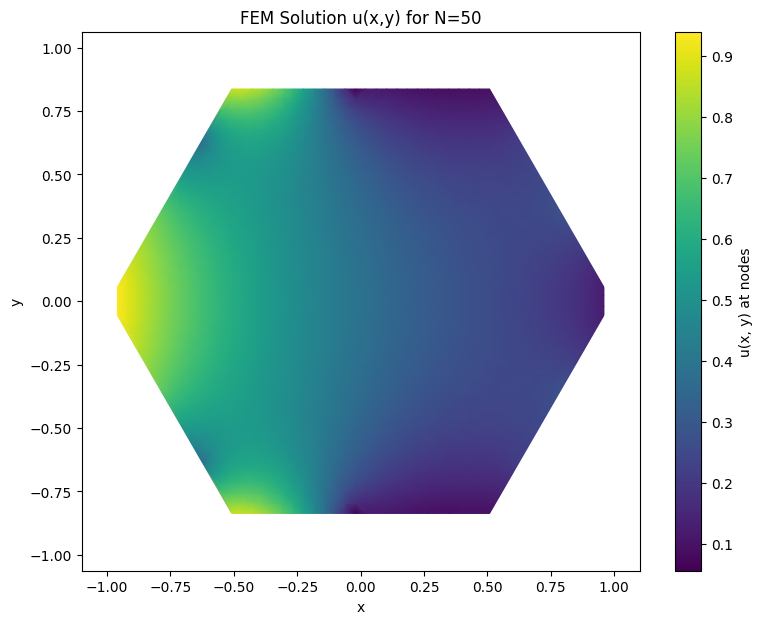

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.spatial import Delaunay
from collections import defaultdict

def solve_and_plot_fem(N=50):
    """
    Solves the Laplace problem on a hexagon using FEM and plots the solution.
    """
    # --- 1. Mesh Generation ---
    hexagon_vertices = np.array([[np.cos(i*np.pi/3), np.sin(i*np.pi/3)] for i in range(6)])
    lines = []
    for i in range(6):
        p1, p2 = hexagon_vertices[i], hexagon_vertices[(i + 1) % 6]
        lines.append([p1[1] - p2[1], p2[0] - p1[0], p1[0] * p2[1] - p2[0] * p1[1]])
    lines = np.array(lines) * np.sign(np.array(lines)[:, 2])[:, np.newaxis]

    def is_inside(points, line_params):
        a = line_params[:, 0].reshape(-1, 1)
        b = line_params[:, 1].reshape(-1, 1)
        c = line_params[:, 2].reshape(-1, 1)
        vals = a * points[:, 0] + b * points[:, 1] + c
        return np.all(vals >= -1e-9, axis=0)

    x_pts = np.linspace(-1, 1, N)
    y_pts = np.linspace(-1, 1, N)
    xv, yv = np.meshgrid(x_pts, y_pts)
    points_grid = np.vstack([xv.ravel(), yv.ravel()]).T
    inside_mask = is_inside(points_grid, lines)
    nodes = points_grid[inside_mask]
    tri = Delaunay(nodes)
    cells = tri.simplices
    num_nodes = len(nodes)

    # --- 2. Assemble Stiffness Matrix A and RHS vector b ---
    A = sp.lil_matrix((num_nodes, num_nodes))
    b = np.zeros(num_nodes)
    for cell in cells:
        p = nodes[cell]
        area = 0.5 * np.abs(p[0,0]*(p[1,1]-p[2,1]) + p[1,0]*(p[2,1]-p[0,1]) + p[2,0]*(p[0,1]-p[1,1]))
        if area < 1e-12: continue
        B = np.array([
            [p[1,1] - p[2,1], p[2,1] - p[0,1], p[0,1] - p[1,1]],
            [p[2,0] - p[1,0], p[0,0] - p[2,0], p[1,0] - p[0,0]]
        ]) / (2 * area)
        Ke = area * (B.T @ B)
        for i in range(3):
            for j in range(3):
                A[cell[i], cell[j]] += Ke[i, j]

    # --- 3. Apply Boundary Conditions ---
    edge_count = defaultdict(int)
    for cell in cells:
        for i in range(3):
            edge = tuple(sorted((cell[i], cell[(i+1)%3])))
            edge_count[edge] += 1
    boundary_edges = [edge for edge, count in edge_count.items() if count == 1]
    boundary_nodes_idx = np.unique(np.array(boundary_edges).flatten())

    node_angles = np.arctan2(nodes[boundary_nodes_idx, 1], nodes[boundary_nodes_idx, 0]) * 3 / np.pi
    node_side_ids = np.round(node_angles).astype(int) % 6
    dirichlet_nodes = boundary_nodes_idx[np.isin(node_side_ids, [0, 2, 4])]

    for edge in boundary_edges:
        p1, p2 = nodes[edge[0]], nodes[edge[1]]
        midpoint = (p1 + p2) / 2
        angle = np.arctan2(midpoint[1], midpoint[0]) * 3 / np.pi
        side_id = np.round(angle).astype(int) % 6
        if side_id in [1, 3, 5]: # Neumann edge
            edge_len = np.linalg.norm(p1 - p2)
            g_N = midpoint[0]**2 - midpoint[1]**2
            b[edge[0]] += g_N * edge_len / 2
            b[edge[1]] += g_N * edge_len / 2

    for node_idx in dirichlet_nodes:
        A[node_idx, :] = 0
        A[node_idx, node_idx] = 1.0
        x, y = nodes[node_idx]
        b[node_idx] = np.sin(np.pi * x) * np.cos(np.pi * y)

    # --- 4. Solve and Plot ---
    print("Solving the linear system...")
    u_vec = spla.spsolve(A.tocsr(), b)
    print("Solver finished.")

    plt.figure(figsize=(9, 7))
    plt.tripcolor(nodes[:, 0], nodes[:, 1], cells, u_vec, cmap='viridis', shading='gouraud')
    plt.title(f"FEM Solution u(x,y) for N={N}")
    plt.colorbar(label='u(x, y) at nodes')

    # Plot hexagon boundary for reference (Corrected)
    # Append the first vertex to the end to close the loop
    plot_vertices = np.vstack([hexagon_vertices, hexagon_vertices[0]])
    plt.plot(plot_vertices[:, 0], plot_vertices[:, 1], 'w-', linewidth=2)

    plt.axis('equal')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# --- Run the Solver and Plotter ---
solve_and_plot_fem()


--- FEM Grid Refinement Study (SciPy-based Mesh) ---
+--------------------+---------------+----------------------+---------------+
|  Grid Density (N)  |  Num. Nodes   |   Solution u(0,0)    |   Time (s)    |
+--------------------+---------------+----------------------+---------------+
|          20          |       228       |      0.3918229482      |     0.0456      |
|          30          |       556       |      0.3390894615      |     0.0656      |
|          40          |       992       |      0.2097974375      |     0.1159      |
|          50          |      1548       |      0.3953027498      |     0.2031      |
+--------------------+---------------+----------------------+---------------+


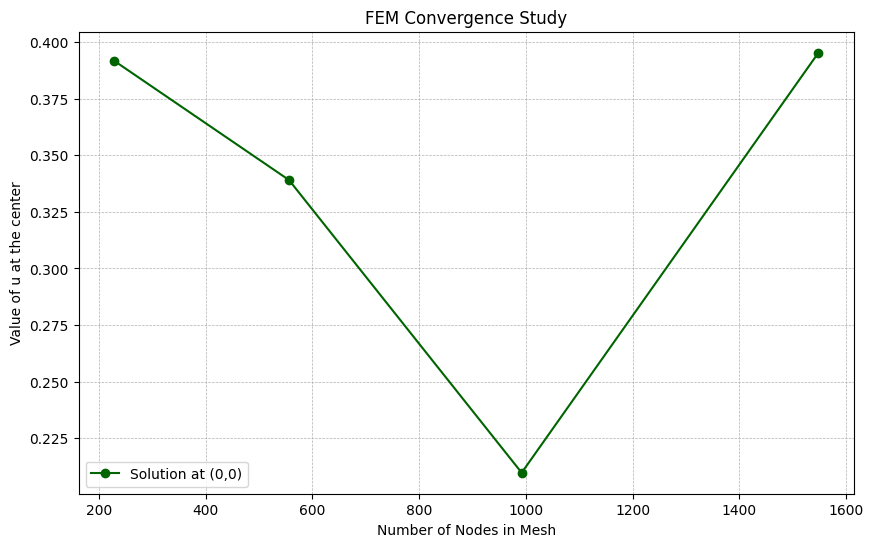

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
from scipy.spatial import Delaunay
from collections import defaultdict

def solve_fem_for_refinement(N):
    """
    A self-contained function to solve the Laplace problem on a hexagon using FEM
    for a given grid point density N and return the solution at the center.
    """
    # --- 1. Mesh Generation ---
    hexagon_vertices = np.array([[np.cos(i*np.pi/3), np.sin(i*np.pi/3)] for i in range(6)])
    lines = []
    for i in range(6):
        p1, p2 = hexagon_vertices[i], hexagon_vertices[(i + 1) % 6]
        lines.append([p1[1] - p2[1], p2[0] - p1[0], p1[0] * p2[1] - p2[0] * p1[1]])
    lines = np.array(lines) * np.sign(np.array(lines)[:, 2])[:, np.newaxis]

    def is_inside(points, line_params):
        """Checks if a set of points is inside the polygon defined by the lines."""
        a = line_params[:, 0].reshape(-1, 1)
        b = line_params[:, 1].reshape(-1, 1)
        c = line_params[:, 2].reshape(-1, 1)
        vals = a * points[:, 0] + b * points[:, 1] + c
        return np.all(vals >= -1e-9, axis=0)

    x_pts = np.linspace(-1, 1, N)
    y_pts = np.linspace(-1, 1, N)
    xv, yv = np.meshgrid(x_pts, y_pts)
    points_grid = np.vstack([xv.ravel(), yv.ravel()]).T
    inside_mask = is_inside(points_grid, lines)
    nodes = points_grid[inside_mask]
    tri = Delaunay(nodes)
    cells = tri.simplices
    num_nodes = len(nodes)

    # --- 2. Assemble and Solve (Condensed for speed) ---
    A = sp.lil_matrix((num_nodes, num_nodes))
    b = np.zeros(num_nodes)
    for cell in cells:
        p = nodes[cell]
        area = 0.5 * np.abs(p[0,0]*(p[1,1]-p[2,1]) + p[1,0]*(p[2,1]-p[0,1]) + p[2,0]*(p[0,1]-p[1,1]))
        if area < 1e-12: continue
        B = np.array([
            [p[1,1] - p[2,1], p[2,1] - p[0,1], p[0,1] - p[1,1]],
            [p[2,0] - p[1,0], p[0,0] - p[2,0], p[1,0] - p[0,0]]
        ]) / (2 * area)
        Ke = area * (B.T @ B)
        for i in range(3):
            for j in range(3):
                A[cell[i], cell[j]] += Ke[i, j]

    edge_count = defaultdict(int)
    for cell in cells:
        for i in range(3):
            edge = tuple(sorted((cell[i], cell[(i+1)%3])))
            edge_count[edge] += 1
    boundary_edges = [edge for edge, count in edge_count.items() if count == 1]
    boundary_nodes_idx = np.unique(np.array(boundary_edges).flatten())
    node_angles = np.arctan2(nodes[boundary_nodes_idx, 1], nodes[boundary_nodes_idx, 0]) * 3 / np.pi
    node_side_ids = np.round(node_angles).astype(int) % 6
    dirichlet_nodes = boundary_nodes_idx[np.isin(node_side_ids, [0, 2, 4])]

    for edge in boundary_edges:
        p1, p2 = nodes[edge[0]], nodes[edge[1]]
        midpoint = (p1 + p2) / 2
        angle = np.arctan2(midpoint[1], midpoint[0]) * 3 / np.pi
        side_id = np.round(angle).astype(int) % 6
        if side_id in [1, 3, 5]:
            edge_len = np.linalg.norm(p1 - p2)
            g_N = midpoint[0]**2 - midpoint[1]**2
            b[edge[0]] += g_N * edge_len / 2
            b[edge[1]] += g_N * edge_len / 2

    for node_idx in dirichlet_nodes:
        A[node_idx, :] = 0
        A[node_idx, node_idx] = 1.0
        x, y = nodes[node_idx]
        b[node_idx] = np.sin(np.pi * x) * np.cos(np.pi * y)

    u_vec = spla.spsolve(A.tocsr(), b)
    center_node_idx = np.argmin(np.linalg.norm(nodes, axis=1))
    return u_vec[center_node_idx], num_nodes

# --- Main Execution for Accuracy Test ---
print("--- FEM Grid Refinement Study (SciPy-based Mesh) ---")
print("+" + "-"*20 + "+" + "-"*15 + "+" + "-"*22 + "+" + "-"*15 + "+")
print(f"| {'Grid Density (N)':^18} | {'Num. Nodes':^13} | {'Solution u(0,0)':^20} | {'Time (s)':^13} |")
print("+" + "-"*20 + "+" + "-"*15 + "+" + "-"*22 + "+" + "-"*15 + "+")

grid_densities = [20, 30, 40, 50]
results = []
num_nodes_list = []

for n_val in grid_densities:
    start_time = time.time()
    u_center, n_nodes = solve_fem_for_refinement(n_val)
    end_time = time.time()
    duration = end_time - start_time
    results.append(u_center)
    num_nodes_list.append(n_nodes)
    print(f"| {n_val:^20} | {n_nodes:^15} | {u_center:^22.10f} | {duration:^15.4f} |")

print("+" + "-"*20 + "+" + "-"*15 + "+" + "-"*22 + "+" + "-"*15 + "+")

# --- Plot Convergence ---
plt.figure(figsize=(10, 6))
plt.plot(num_nodes_list, results, 'o-', color='darkgreen', label='Solution at (0,0)')
plt.title('FEM Convergence Study')
plt.xlabel('Number of Nodes in Mesh')
plt.ylabel('Value of u at the center')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


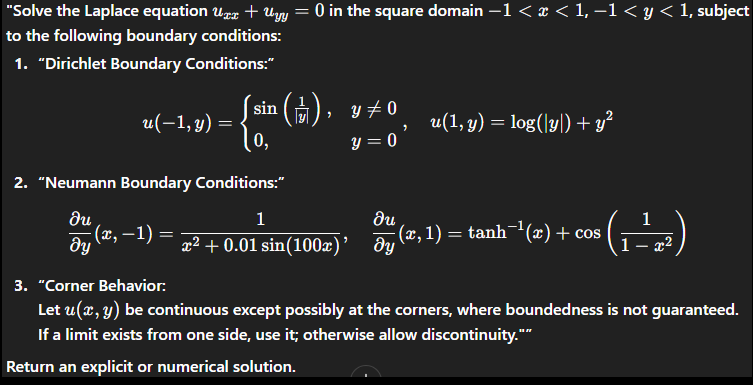

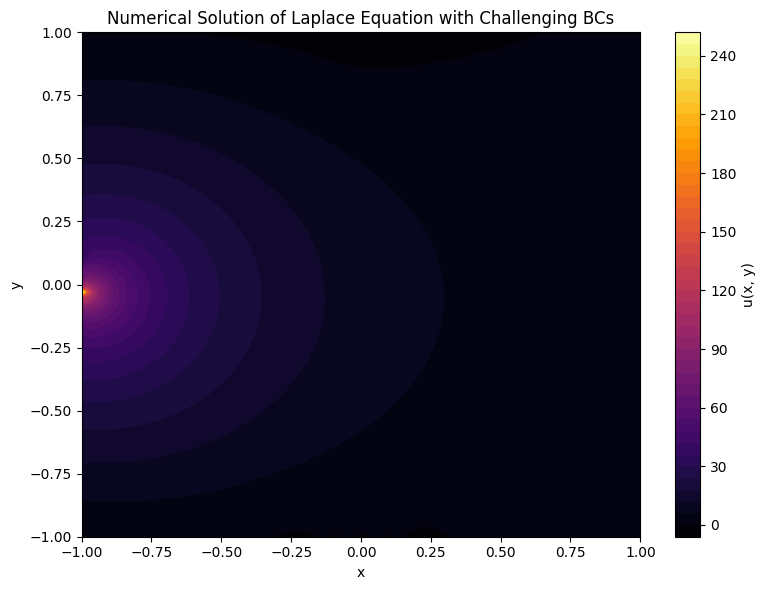

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Domain parameters
N = 100  # Grid size (N x N)
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
h = x[1] - x[0]
X, Y = np.meshgrid(x, y, indexing='ij')

# Initialize u with zeros
u = np.zeros((N, N))

# Apply Dirichlet BCs on x = -1 and x = 1
for j in range(N):
    yj = y[j]
    # Left boundary: u(-1, y)
    if yj != 0:
        u[0, j] = np.sin(1 / abs(yj))
    else:
        u[0, j] = 0

    # Right boundary: u(1, y)
    if yj != 0:
        u[-1, j] = np.log(abs(yj)) + yj**2
    else:
        u[-1, j] = -100  # simulate log(0) ~ -inf

# Neumann BCs for y = -1 (bottom) and y = 1 (top)
def apply_neumann_bc(u):
    for i in range(1, N - 1):
        xi = x[i]

        # Bottom boundary: forward difference
        denom = xi**2 + 0.01 * np.sin(100 * xi)
        if denom != 0:
            u[i, 0] = u[i, 1] - h * (1 / denom)
        else:
            u[i, 0] = u[i, 1]  # fallback

        # Top boundary: backward difference
        if abs(xi) < 1:
            try:
                neumann_val = np.arctanh(xi) + np.cos(1 / (1 - xi**2))
                u[i, -1] = u[i, -2] + h * neumann_val
            except:
                u[i, -1] = u[i, -2]  # fallback if unstable
        else:
            u[i, -1] = u[i, -2]

# Gauss-Seidel solver
def solve_laplace(u, max_iter=5000, tol=1e-4):
    for it in range(max_iter):
        u_old = u.copy()
        apply_neumann_bc(u)

        for i in range(1, N - 1):
            for j in range(1, N - 1):
                if i == 0 or i == N - 1:
                    continue  # skip Dirichlet BCs
                u[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1])

        diff = np.linalg.norm(u - u_old)
        if diff < tol:
            print(f"Converged in {it} iterations.")
            break
    return u

# Solve and plot
u_final = solve_laplace(u)

plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, u_final.T, 50, cmap='inferno')
plt.colorbar(cp, label='u(x, y)')
plt.title('Numerical Solution of Laplace Equation with Challenging BCs')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()


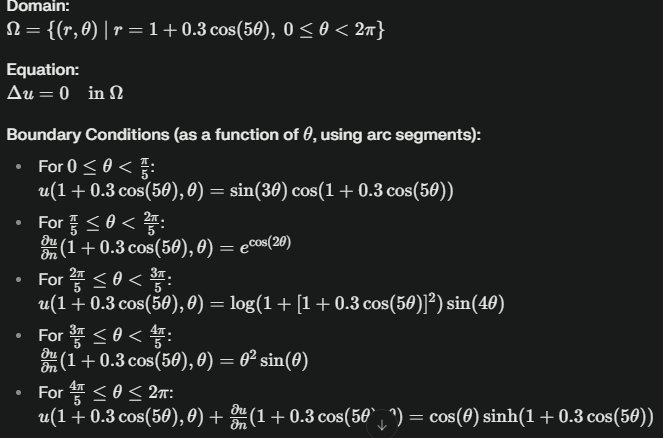

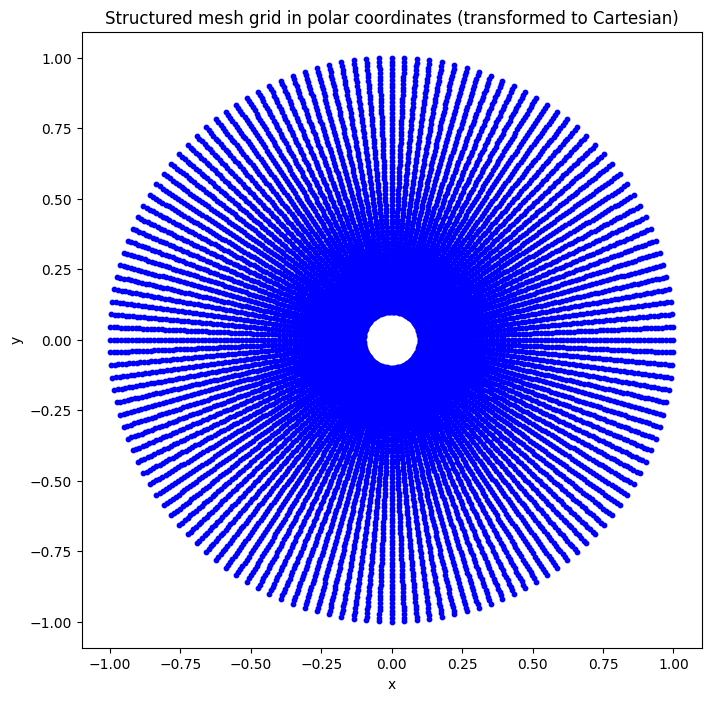

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Mesh parameters
N_r = 70            # Radial divisions
N_theta = 140       # Angular divisions
r_in = 0.1

# Angular and radial grids
theta = np.linspace(0, 2*np.pi, N_theta, endpoint=False)
r = np.linspace(r_in, 1.0, N_r)

# Meshgrid in (r, theta)
RR, TT = np.meshgrid(r, theta, indexing='ij')  # shape (N_r, N_theta)

# Convert to Cartesian coordinates
XX = RR * np.cos(TT)
YY = RR * np.sin(TT)

# Visualization
plt.figure(figsize=(8, 8))
plt.scatter(XX, YY, s=10, color='blue', marker='o')
plt.title('Structured mesh grid in polar coordinates (transformed to Cartesian)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()


C:\Users\91831\AppData\Local\Temp\ipykernel_34696\2962491929.py:84: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(XX, YY, U, shading='auto', cmap='viridis')


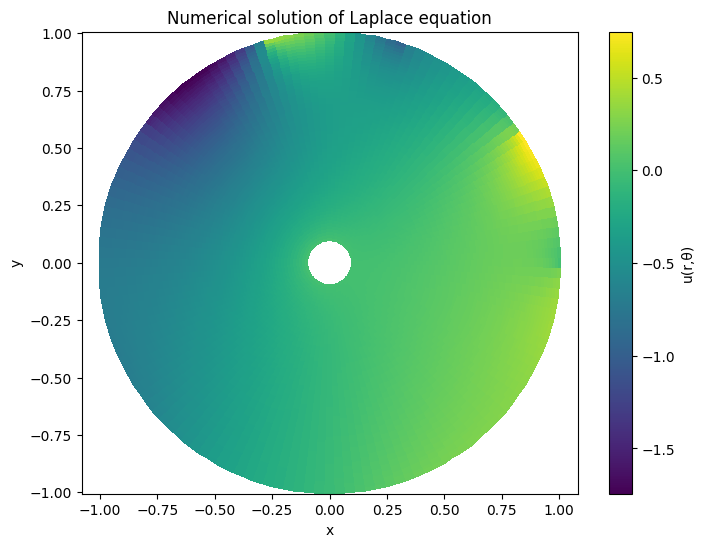

In [28]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt

# Parameters
N_r = 70            # Number of radial points (fine)
N_theta = 140       # Number of angular points (fine)
r_in = 0.1
theta = np.linspace(0, 2*np.pi, N_theta, endpoint=False)
r_boundary = 1.0 + 0.3 * np.cos(5 * theta)
r = np.linspace(r_in, 1.0, N_r)   # Uniform grid from r_in to outer (mapped) boundary
dr = r[1] - r[0]
dtheta = theta[1] - theta[0]

# Helper for linear index
def idx(i, j):
    return i * N_theta + j

# Assemble system
A = lil_matrix((N_r*N_theta, N_r*N_theta))
b = np.zeros(N_r*N_theta)
for i in range(1, N_r-1):
    for j in range(N_theta):
        jp = (j + 1) % N_theta
        jm = (j - 1) % N_theta
        r_ = r[i]
        # Polar Laplacian stencil
        A[idx(i, j), idx(i+1, j)] = (1/(dr**2) + 1/(2*r_*dr))
        A[idx(i, j), idx(i-1, j)] = (1/(dr**2) - 1/(2*r_*dr))
        A[idx(i, j), idx(i, jp)] = 1/(r_**2 * dtheta**2)
        A[idx(i, j), idx(i, jm)] = 1/(r_**2 * dtheta**2)
        A[idx(i, j), idx(i, j)] = -2/(dr**2) - 2/(r_**2 * dtheta**2)
        b[idx(i, j)] = 0

# Outer boundary
for j in range(N_theta):
    theta_ = theta[j]
    i = N_r - 1
    r_b = r_boundary[j]
    # Arc mapping
    if 0 <= theta_ < np.pi/5:
        # Dirichlet
        A[idx(i, j), idx(i, j)] = 1.0
        b[idx(i, j)] = np.sin(3*theta_) * np.cos(1 + 0.3*np.cos(5*theta_))
    elif np.pi/5 <= theta_ < 2*np.pi/5:
        # Neumann (finite diff forward)
        A[idx(i, j), idx(i, j)] = -1/dr
        A[idx(i, j), idx(i-1, j)] = 1/dr
        b[idx(i, j)] = np.exp(np.cos(2*theta_)) / r_b
    elif 2*np.pi/5 <= theta_ < 3*np.pi/5:
        # Dirichlet
        A[idx(i, j), idx(i, j)] = 1.0
        val = np.log(1 + (1 + 0.3*np.cos(5*theta_))**2) * np.sin(4*theta_)
        b[idx(i, j)] = val
    elif 3*np.pi/5 <= theta_ < 4*np.pi/5:
        # Neumann
        A[idx(i, j), idx(i, j)] = -1/dr
        A[idx(i, j), idx(i-1, j)] = 1/dr
        b[idx(i, j)] = (theta_**2 * np.sin(theta_)) / r_b
    else:
        # Robin (u + du/dn = cos(theta)sinh(r))
        A[idx(i, j), idx(i, j)] = 1 + 1/dr
        A[idx(i, j), idx(i-1, j)] = -1/dr
        b[idx(i, j)] = np.cos(theta_) * np.sinh(1 + 0.3*np.cos(5*theta_))

# Inner boundary (homogeneous Dirichlet)
for j in range(N_theta):
    A[idx(0, j), idx(0, j)] = 1
    b[idx(0, j)] = 0

# Solve
u = spsolve(A.tocsr(), b)
U = u.reshape((N_r, N_theta))

# Convert to Cartesian for plotting
RR, TT = np.meshgrid(r, theta, indexing='ij')
XX = RR * np.cos(TT)
YY = RR * np.sin(TT)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.pcolormesh(XX, YY, U, shading='auto', cmap='viridis')
plt.colorbar(label='u(r,θ)')
plt.title('Numerical solution of Laplace equation')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()


In [29]:
residual = np.zeros_like(U)
for i in range(1, N_r-1):
    for j in range(N_theta):
        jp = (j + 1) % N_theta
        jm = (j - 1) % N_theta
        r_ = r[i]
        laplacian = (
            (U[i+1, j] - 2*U[i, j] + U[i-1, j]) / dr**2 +
            (1/r_) * (U[i+1, j] - U[i-1, j]) / (2*dr) +
            (U[i, jp] - 2*U[i, j] + U[i, jm]) / (r_**2 * dtheta**2)
        )
        residual[i, j] = laplacian
print("Max residual:", np.abs(residual[1:-1,:]).max())


Max residual: 1.1180389947185176e-11
